In [183]:
import sys
sys.path.insert(0, '..')

import pandas as pd
from torch.utils.data import Dataset, DataLoader
from astropy.io import fits
import json
import os
from io import BytesIO
from scipy import stats
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.optim import AdamW
import torch.nn.functional as F
from torch.nn.functional import sigmoid
from datetime import datetime
import random
from tqdm import tqdm
import umap
from sklearn.preprocessing import LabelEncoder

from util.parallelzipfile import ParallelZipFile as ZipFile
from util.preprocess_data import clip_outliers
from models.Informer import DataEmbedding, EncoderLayer, AttentionLayer, ProbAttention, Encoder
from core.multimodal.model import ModelV0
from core.multimodal.dataset import VPSMDataset

In [184]:
def set_random_seeds(random_seed):
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    torch.backends.cudnn.deterministic = True


def get_config(random_seed):
    config = {
        'project': 'multimodal-contrastive',
        'random_seed': random_seed,
        'use_wandb': False,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        'use_pretrain': None,

        # Data General
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'spectra_v_merged_fixed.csv',
        'classes': None,
        'min_samples': 200,
        'max_samples': None,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': True,
        'clip': False,
        'aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        'spectra_v_file': 'spectra_v_merged.csv',
        'z_corr': False,

        # Photometry Model
        'p_encoder_layers': 8,
        'p_d_model': 128,
        'p_dropout': 0,
        'p_feature_size': 3,
        'p_n_heads': 4,
        'p_d_ff': 512,

        # Spectra Model
        's_hidden_dim': 512,
        's_dropout': 0,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0,

        # MultiModal Model
        'hidden_dim': 256,

        # Training
        'batch_size': 32,
        'lr': 1e-3,
        'weight_decay': 0,
        'epochs': 50,
        'optimizer': 'AdamW',
        'early_stopping_patience': 10,

        # Learning Rate Scheduler
        'factor': 0.3,
        'patience': 5,
    }

    config['p_feature_size'] += 4

    return config

In [20]:
random_seed = 66
set_random_seeds(random_seed)
config = get_config(random_seed)

In [21]:
train_dataset = VPSMDataset(
    data_root=config['data_root'], file=config['file'], split='train', min_samples=config['min_samples'],
    max_samples=config['max_samples'], classes=config['classes'], random_seed=config['random_seed'], verbose=True,
    v_zip=config['v_zip'], v_prefix=config['v_prefix'], seq_len=config['seq_len'], phased=config['phased'],
    clip=config['clip'], aux=config['aux'], lamost_spec_dir=config['lamost_spec_dir'],
    spectra_v_file=config['spectra_v_file'], z_corr=config['z_corr']
)
val_dataset = VPSMDataset(
    data_root=config['data_root'], file=config['file'], split='val', min_samples=config['min_samples'],
    max_samples=config['max_samples'], classes=config['classes'], random_seed=config['random_seed'], verbose=True,
    v_zip=config['v_zip'], v_prefix=config['v_prefix'], seq_len=config['seq_len'], phased=config['phased'],
    clip=config['clip'], aux=config['aux'], lamost_spec_dir=config['lamost_spec_dir'],
    spectra_v_file=config['spectra_v_file'], z_corr=config['z_corr']
)

/global/home/users/mariia/AstroML/notebooks/../core/multimodal/dataset.py:43: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(data_root, file))


Dropping nan values... Done. Left with 22065 rows.
Removing objects that have more than None or less than 200 samples... 21777 objects left.
train split is selected: 17421 objects left.


/global/home/users/mariia/AstroML/notebooks/../core/multimodal/dataset.py:43: DtypeWarning: Columns (69) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(os.path.join(data_root, file))


Dropping nan values... Done. Left with 22065 rows.
Removing objects that have more than None or less than 200 samples... 21777 objects left.
val split is selected: 2178 objects left.


In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [72]:
model = ModelV0(config)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
criterion = nn.BCEWithLogitsLoss()

In [73]:
model.load_state_dict(torch.load('/home/mariia/AstroML/weights/2024-05-31-19-07-v1zquk8u/weights-33.pth'))

<All keys matched successfully>

In [38]:
def get_embeddings(photometry, photometry_mask, spectra, metadata):
    p_emb = model.photometry_proj(model.photometry_encoder(photometry, photometry_mask))
    s_emb = model.spectra_proj(model.spectra_encoder(spectra))
    m_emb = model.metadata_proj(model.metadata_encoder(metadata))
    
    return p_emb, s_emb, m_emb
        
def step(el1, el2):
    p, p_mask, s, m = el1
    p2, p_mask2, s2, m2 = el2

    p, p_mask, s, m = p.to(device), p_mask.to(device), s.to(device), m.to(device)
    p2, p_mask2, s2, m2 = p2.to(device), p_mask2.to(device), s2.to(device), m2.to(device)

    ps_sim, mp_sim, sm_sim = model((p, p_mask, s, m), (p2, p_mask2, s2, m2))

    return ps_sim, mp_sim, sm_sim

In [88]:
train_dataset.df['variable_type'].value_counts()

variable_type
EW      5054
SR      3725
EA      2354
RRAB    1946
EB      1570
ROT     1494
RRC      647
HADS     232
M        207
DSCT     192
Name: count, dtype: int64

In [90]:
(photometry, photometry_mask, spectra, metadata), (photometry2, photometry_mask2, spectra2, metadata2), y = train_dataset[0]

In [109]:
el1, el2, y = next(iter(train_dataloader))

In [122]:
y = y.to(device)

In [111]:
photometry1, photometry_mask1, spectra1, metadata1 = el1
photometry1, photometry_mask1, spectra1, metadata1 = photometry1.to(device), photometry_mask1.to(device), spectra1.to(device), metadata1.to(device)
p_emb1, s_emb1, m_emb1 = get_embeddings(photometry1, photometry_mask1, spectra1, metadata1)

photometry2, photometry_mask2, spectra2, metadata2 = el2
photometry2, photometry_mask2, spectra2, metadata2 = photometry2.to(device), photometry_mask2.to(device), spectra2.to(device), metadata2.to(device)
p_emb2, s_emb2, m_emb2 = get_embeddings(photometry2, photometry_mask2, spectra2, metadata2)

In [112]:
cos = nn.CosineSimilarity(dim=-1)

In [113]:
cos(p_emb1, p_emb2)

tensor([-0.3953, -0.8106,  0.2475, -0.1687,  0.1127,  0.9972,  0.9772, -0.1560,
         0.1973, -0.4956, -0.1255,  0.9995,  0.9684,  0.8254, -0.4924,  0.0458,
         0.1033,  0.0589,  0.5924,  0.9696, -0.5716, -0.2145,  0.6245,  0.5976,
        -0.0763,  0.9984, -0.7523,  0.8116,  0.9913, -0.0788, -0.8403,  0.8855],
       device='cuda:0', grad_fn=<SumBackward1>)

In [114]:
sigmoid(cos(p_emb1, p_emb2))

tensor([0.4024, 0.3078, 0.5616, 0.4579, 0.5281, 0.7305, 0.7266, 0.4611, 0.5492,
        0.3786, 0.4687, 0.7310, 0.7248, 0.6954, 0.3793, 0.5115, 0.5258, 0.5147,
        0.6439, 0.7250, 0.3609, 0.4466, 0.6512, 0.6451, 0.4809, 0.7307, 0.3203,
        0.6925, 0.7293, 0.4803, 0.3015, 0.7080], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [115]:
sigmoid(cos(s_emb1, s_emb2))

tensor([0.2835, 0.3051, 0.4575, 0.7298, 0.5377, 0.6674, 0.7278, 0.5352, 0.7197,
        0.4728, 0.2815, 0.7310, 0.7287, 0.6782, 0.6763, 0.6775, 0.5358, 0.5108,
        0.3106, 0.6734, 0.7003, 0.2879, 0.6898, 0.6573, 0.3110, 0.7257, 0.2778,
        0.4120, 0.6000, 0.5125, 0.5017, 0.7021], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [116]:
sigmoid(cos(m_emb1, m_emb2))

tensor([0.3233, 0.3070, 0.4926, 0.7300, 0.3193, 0.7254, 0.7152, 0.3903, 0.7009,
        0.4999, 0.3575, 0.7307, 0.6597, 0.7276, 0.5003, 0.6537, 0.5204, 0.4821,
        0.2769, 0.7104, 0.7284, 0.3332, 0.7266, 0.6932, 0.4077, 0.7268, 0.2904,
        0.7220, 0.4727, 0.3479, 0.5190, 0.7262], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [128]:
((sigmoid(cos(p_emb1, p_emb2)) + sigmoid(cos(s_emb1, s_emb2)) + sigmoid(cos(m_emb1, m_emb2))) / 3 > 0.5).float()

tensor([0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1.],
       device='cuda:0')

In [129]:
y

tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')

In [133]:
model.eval()

all_true_labels = []
all_predicted_labels = []
p_embs1, p_embs2, s_embs1, s_embs2, m_embs1, m_embs2 = [], [], [], [], [], []

for el1, el2, y in tqdm(val_dataloader):
    with torch.no_grad():
        photometry1, photometry_mask1, spectra1, metadata1 = el1
        photometry1, photometry_mask1, spectra1, metadata1 = photometry1.to(device), photometry_mask1.to(device), spectra1.to(device), metadata1.to(device)
        p_emb1, s_emb1, m_emb1 = get_embeddings(photometry1, photometry_mask1, spectra1, metadata1)
        
        photometry2, photometry_mask2, spectra2, metadata2 = el2
        photometry2, photometry_mask2, spectra2, metadata2 = photometry2.to(device), photometry_mask2.to(device), spectra2.to(device), metadata2.to(device)
        p_emb2, s_emb2, m_emb2 = get_embeddings(photometry2, photometry_mask2, spectra2, metadata2)

        probabilities = (sigmoid(cos(p_emb1, p_emb2)) + sigmoid(cos(s_emb1, s_emb2)) + sigmoid(cos(m_emb1, m_emb2))) / 3
        predicted_labels = (probabilities >= 0.5).float()

        all_true_labels.extend(y.numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

        p_embs1.append(p_emb1)
        p_embs2.append(p_emb2)
        s_embs1.append(s_emb1)
        s_embs2.append(s_emb2)
        m_embs1.append(m_emb1)
        m_embs2.append(m_emb2)

100%|█████████████████████████████████████████████████████████████████████████████████| 69/69 [01:08<00:00,  1.00it/s]


Text(0.5, 1.0, 'Confusion Matrix - Percentages')

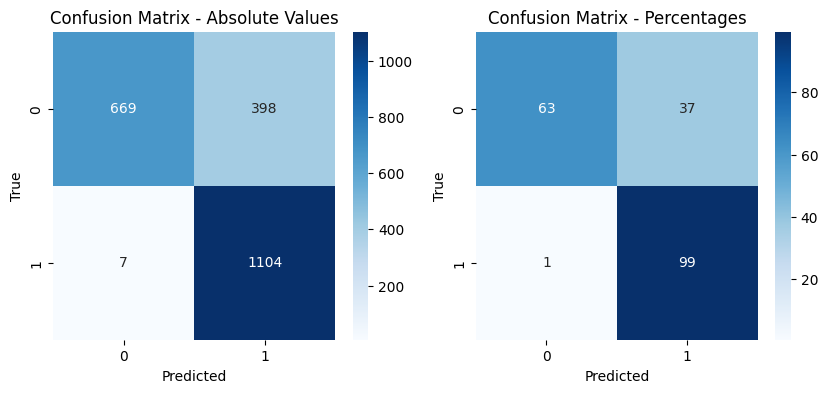

In [143]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Calculate percentage values for confusion matrix
conf_matrix_percent = 100 * conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot both confusion matrices side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot absolute values confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix - Absolute Values')

# Plot percentage values confusion matrix
sns.heatmap(conf_matrix_percent, annot=True, fmt='.0f', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix - Percentages')

In [146]:
photometry, photometry_mask, spectra, metadata, label = train_dataset.get_el(0)

In [155]:
p_emb, s_emb, m_emb = get_embeddings(torch.tensor(photometry).to(device).unsqueeze(0), torch.tensor(photometry_mask).to(device).unsqueeze(0), 
                                     torch.tensor(spectra).to(device).unsqueeze(0), torch.tensor(metadata).to(device).unsqueeze(0))

In [156]:
p_emb.shape, s_emb.shape, m_emb.shape

(torch.Size([1, 256]), torch.Size([1, 256]), torch.Size([1, 256]))

In [214]:
p_embeddings, s_embeddings, m_embeddings, labels = [], [], [], []
labels = []

for i in tqdm(range(len(val_dataset))):
    photometry, photometry_mask, spectra, metadata, label = val_dataset.get_el(i)
    p_emb, s_emb, m_emb = get_embeddings(torch.tensor(photometry).to(device).unsqueeze(0), 
                                         torch.tensor(photometry_mask).to(device).unsqueeze(0), 
                                         torch.tensor(spectra).to(device).unsqueeze(0), 
                                         torch.tensor(metadata).to(device).unsqueeze(0))
    p_embeddings.append(p_emb.cpu().detach().numpy())
    s_embeddings.append(s_emb.cpu().detach().numpy())
    m_embeddings.append(m_emb.cpu().detach().numpy())
    labels.append(label)

100%|█████████████████████████████████████████████████████████████████████████████| 2178/2178 [01:16<00:00, 28.52it/s]


In [215]:
p_embeddings = np.array(p_embeddings)[:, 0]
s_embeddings = np.array(s_embeddings)[:, 0]
m_embeddings = np.array(m_embeddings)[:, 0]

embeddings = np.concatenate([p_embeddings, s_embeddings, m_embeddings], axis=0)

In [216]:
modality_labels = np.array([f'{val_dataset.id2target[label]}_photometry' for label in labels] +
                           [f'{val_dataset.id2target[label]}_spectra' for label in labels] +
                           [f'{val_dataset.id2target[label]}_metadata' for label in labels])

In [193]:
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(embeddings)

In [194]:
umap_emb.shape

(6534, 2)

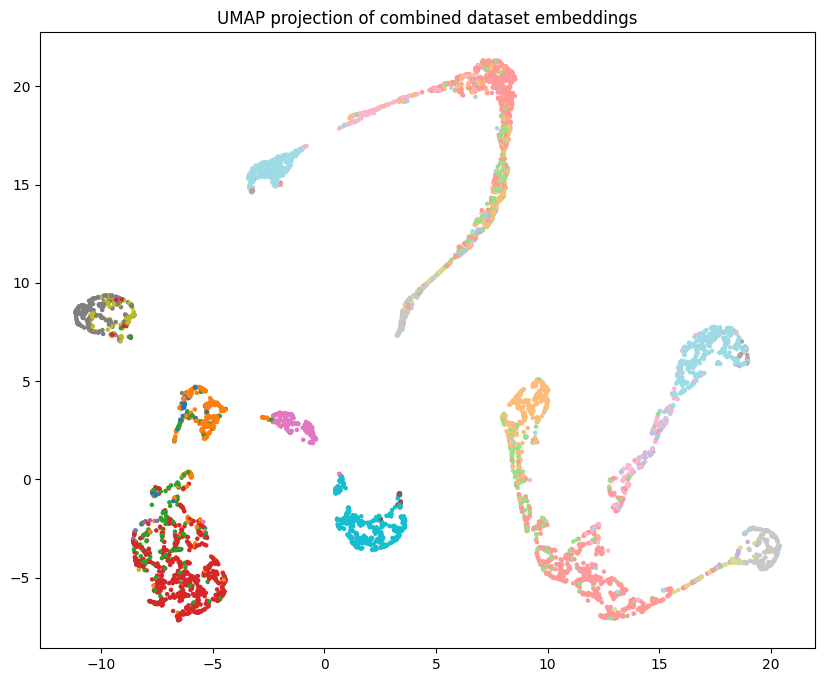

In [200]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=numeric_labels, cmap='tab20', s=5)
plt.clim(-0.5, len(le.classes_)-0.5)
plt.title('UMAP projection of combined dataset embeddings')
plt.show()

In [202]:
p_umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(p_embeddings)

In [210]:
p_umap_emb.shape

(2178, 2)

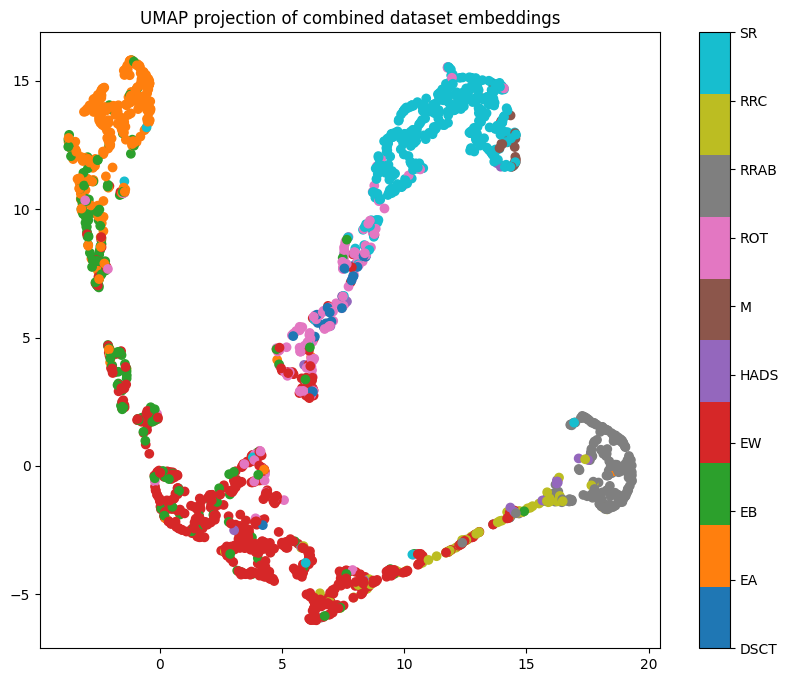

In [228]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(p_umap_emb[:, 0], p_umap_emb[:, 1], c=labels, cmap='tab10')
plt.title('UMAP projection of combined dataset embeddings')
cbar = plt.colorbar(scatter, ticks=range(val_dataset.num_classes))
cbar.ax.set_yticklabels(val_dataset.target2id.keys())
plt.show()

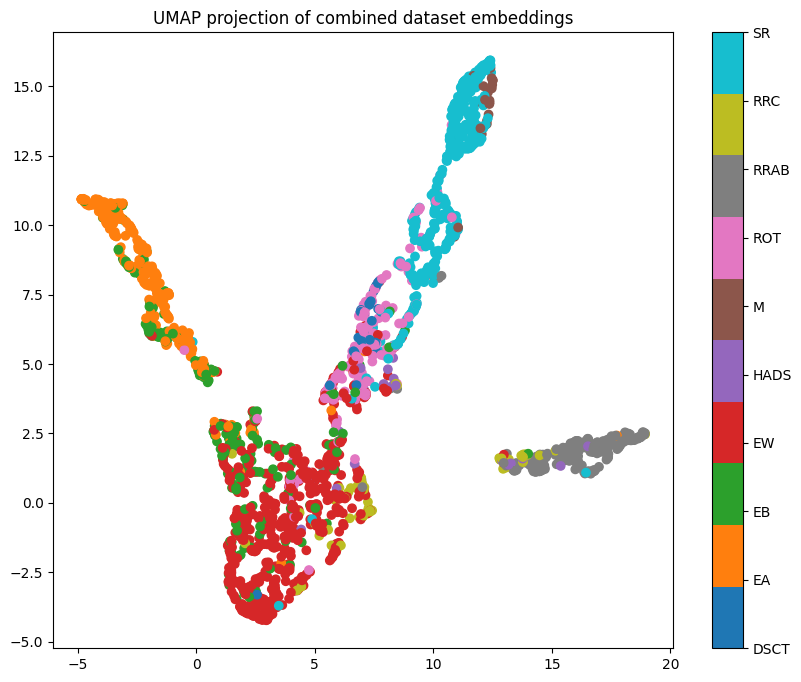

In [229]:
p_umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(p_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(p_umap_emb[:, 0], p_umap_emb[:, 1], c=labels, cmap='tab10')
plt.title('UMAP projection of combined dataset embeddings')
cbar = plt.colorbar(scatter, ticks=range(val_dataset.num_classes))
cbar.ax.set_yticklabels(val_dataset.target2id.keys())
plt.show()

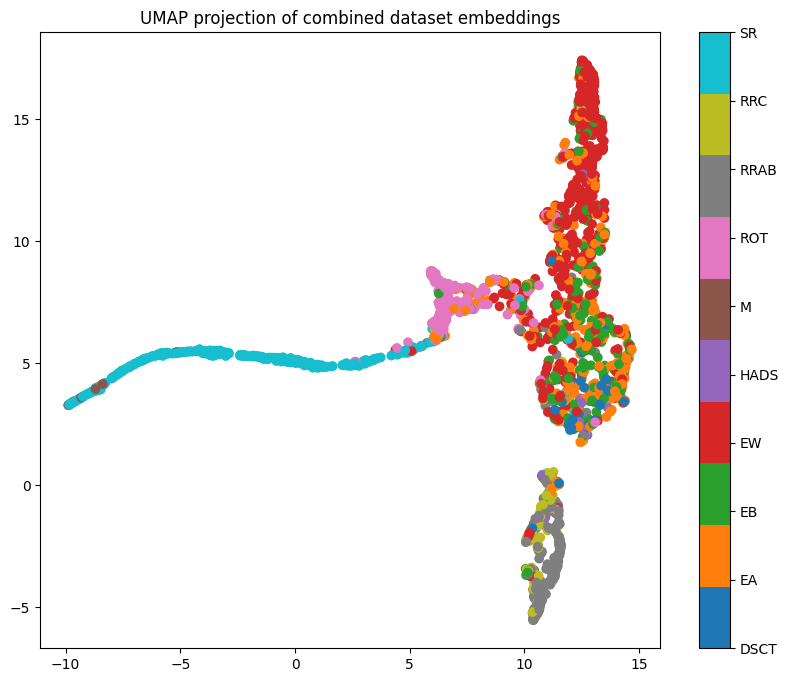

In [230]:
s_umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(s_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(s_umap_emb[:, 0], s_umap_emb[:, 1], c=labels, cmap='tab10')
plt.title('UMAP projection of combined dataset embeddings')
cbar = plt.colorbar(scatter, ticks=range(val_dataset.num_classes))
cbar.ax.set_yticklabels(val_dataset.target2id.keys())
plt.show()

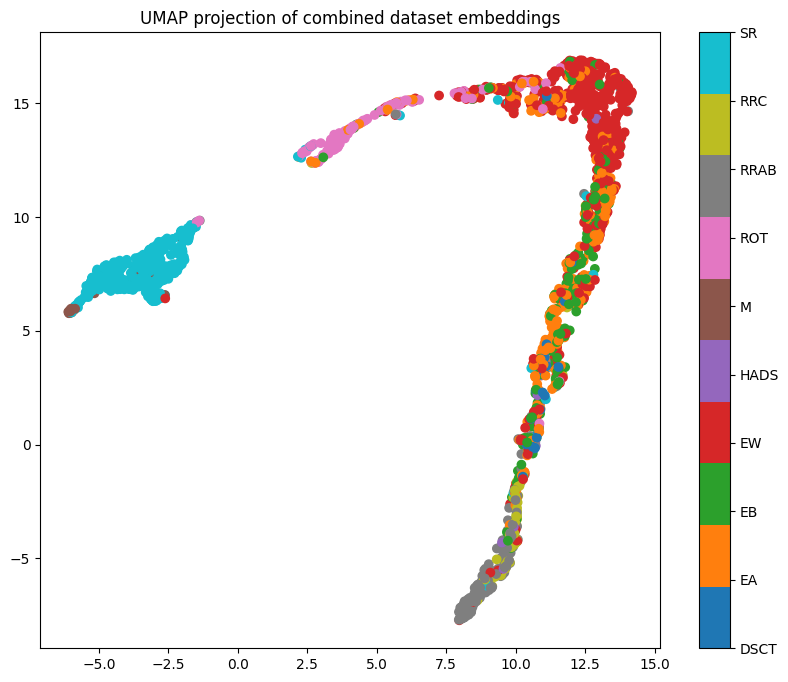

In [232]:
s_umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(s_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(s_umap_emb[:, 0], s_umap_emb[:, 1], c=labels, cmap='tab10')
plt.title('UMAP projection of combined dataset embeddings')
cbar = plt.colorbar(scatter, ticks=range(val_dataset.num_classes))
cbar.ax.set_yticklabels(val_dataset.target2id.keys())
plt.show()

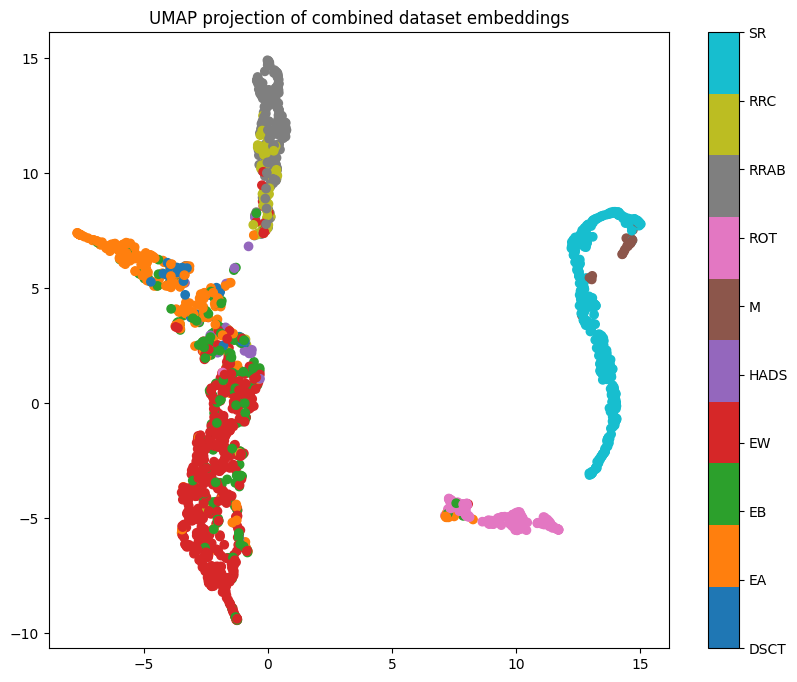

In [231]:
m_umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(m_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(m_umap_emb[:, 0], m_umap_emb[:, 1], c=labels, cmap='tab10')
plt.title('UMAP projection of combined dataset embeddings')
cbar = plt.colorbar(scatter, ticks=range(val_dataset.num_classes))
cbar.ax.set_yticklabels(val_dataset.target2id.keys())
plt.show()

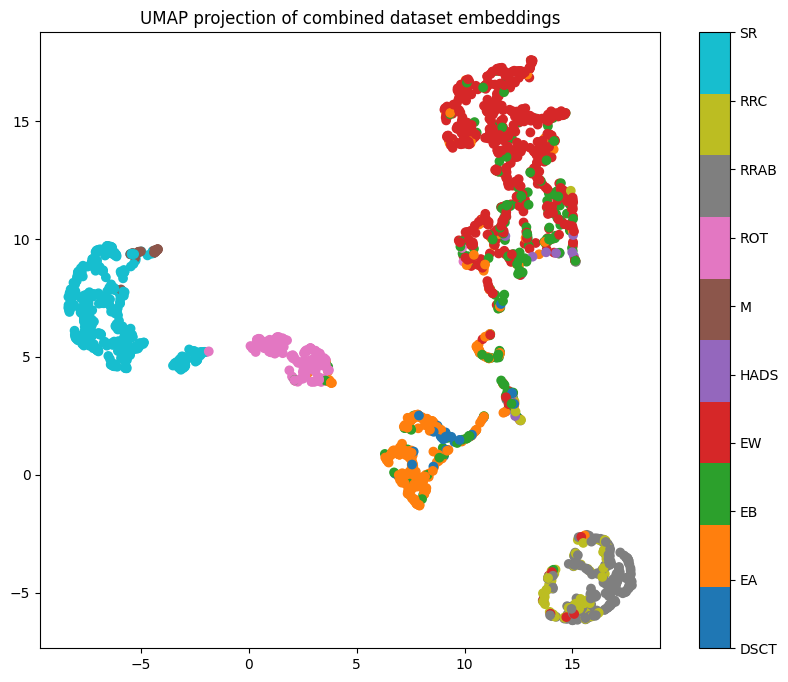

In [233]:
m_umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(m_embeddings)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(m_umap_emb[:, 0], m_umap_emb[:, 1], c=labels, cmap='tab10')
plt.title('UMAP projection of combined dataset embeddings')
cbar = plt.colorbar(scatter, ticks=range(val_dataset.num_classes))
cbar.ax.set_yticklabels(val_dataset.target2id.keys())
plt.show()